# BOND YIELD CURVE INVERSION: Forecasting a Recession

A deeper dive into [U.S. Department of the Treasury](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield) Yield Curve data and it's predictive capaiblities. 

In an efficiently performing market, long-term bonds have higher bond yield rates than shorter-term bonds, T-notes, and T-bills as the market expects greater risk in investing in long-term bonds (a lot can happen in 30 years). However, when the yield curve inverts, the bond yield rates for shorter-term bonds are higher than long-term bond yield rates. An Inverted Yield Curve is used as one predictor of a recession as it captures the nervousness of investors about the near term market outlook.

In my analysis below, an Inverted Yield Curve occurs when the ratio of long-term bond rates (i.e. 30 years, 10 years) versus short-term bonds(6 months, 1 year, 10 years) is between 0 and 1. The yield curve last inverted between 2006 and 2007. 

#### Jupyter Notebook - Web based IDE, particularly useful for data munging and cleansing and quick analysis https://jupyter.org/

In [1]:
%matplotlib inline
import requests
import xml.etree.ElementTree as et
from xml.parsers.expat import ExpatError
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import urllib.request as urllib2

## Retrieving and Organizing the Data

The following code demonstrates scraping the Treasury website and organizing the data into a Pandas dataframe.

#### US Treasury Daily Yield Curve Rates - https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

In [2]:
#---- Scrape XML From Treasury Website ----#
year  = 2020
curpath = os.path.dirname(os.path.realpath("./yield"))
data_dir = data_dir = curpath + '/data/xml'
while (year <=2020):
    filename = os.path.join(data_dir, '%s.xml' %year )
    resp = urllib2.urlopen('http://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=year(NEW_DATE)%20eq%20'+ str(year))
    xml = resp.read()
    with open(filename, "wb") as file:
        file.write(xml)
        print("Pulled file: %s" % filename)    
    year += 1

Pulled file: /opt/yield/data/xml/2020.xml


In [3]:
#-------- Retrieve XML Files --------#
# Current  directory:
curpath = os.path.dirname( os.path.abspath("./yield/"))

# Traverse a directory
data_dir = curpath + '/data/'
def traverse_directory(directory):
    files = [directory+f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return files

In [4]:
# ----Prepend Namespaces for Retrieval ----#
def prepend_atom(s):
    return '{http://www.w3.org/2005/Atom}' + s

def prepend_schema(s):
    return '{http://schemas.microsoft.com/ado/2007/08/dataservices/metadata}%s' % s

def prepend_ds(s):
    return '{http://schemas.microsoft.com/ado/2007/08/dataservices}%s' % s

#### XML Element Tree API - Traverse an XML tree https://docs.python.org/2/library/xml.etree.elementtree.html

In [5]:
#   <entry>
#     <id>http://data.treasury.gov/Feed.svc/DailyTreasuryYieldCurveRateData(7529)</id>
#     <title type="text"></title>
#     <updated>2020-02-17T17:10:05Z</updated>
#     <author>
#       <name />
#     </author>
#     <link rel="edit" title="DailyTreasuryYieldCurveRateDatum" href="DailyTreasuryYieldCurveRateData(7529)" />
#     <category term="TreasuryDataWarehouseModel.DailyTreasuryYieldCurveRateDatum" scheme="http://schemas.microsoft.com/ado/2007/08/dataservices/scheme" />
#     <content type="application/xml">
#       <m:properties>
#         <d:Id m:type="Edm.Int32">7529</d:Id>
#         <d:NEW_DATE m:type="Edm.DateTime">2020-02-03T00:00:00</d:NEW_DATE>
#         <d:BC_1MONTH m:type="Edm.Double">1.56</d:BC_1MONTH>
#         <d:BC_2MONTH m:type="Edm.Double">1.57</d:BC_2MONTH>
#         <d:BC_3MONTH m:type="Edm.Double">1.57</d:BC_3MONTH>
#         <d:BC_6MONTH m:type="Edm.Double">1.56</d:BC_6MONTH>
#         <d:BC_1YEAR m:type="Edm.Double">1.46</d:BC_1YEAR>
#         <d:BC_2YEAR m:type="Edm.Double">1.36</d:BC_2YEAR>
#         <d:BC_3YEAR m:type="Edm.Double">1.34</d:BC_3YEAR>
#         <d:BC_5YEAR m:type="Edm.Double">1.35</d:BC_5YEAR>
#         <d:BC_7YEAR m:type="Edm.Double">1.45</d:BC_7YEAR>
#         <d:BC_10YEAR m:type="Edm.Double">1.54</d:BC_10YEAR>
#         <d:BC_20YEAR m:type="Edm.Double">1.84</d:BC_20YEAR>
#         <d:BC_30YEAR m:type="Edm.Double">2.01</d:BC_30YEAR>
#         <d:BC_30YEARDISPLAY m:type="Edm.Double">2.01</d:BC_30YEARDISPLAY>
#       </m:properties>
#     </content>
#   </entry>

In [6]:
# ----Build a Dictionary of All Entries from 1990 to Present  ----#
def build_entries_dict(count, dentries, root):
    for elem in root.findall(prepend_atom('entry')):
        count +=1
        dentry = {}
        properties = elem.find(prepend_atom('content')).find(prepend_schema('properties'))
        iid = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('Id')).text
        date = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('NEW_DATE')).text
        bc_1month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_1MONTH')).text
        bc_3month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_3MONTH')).text
        bc_6month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_6MONTH')).text
        bc_1yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_1YEAR')).text
        bc_2yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_2YEAR')).text
        bc_3yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_3YEAR')).text
        bc_5yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_5YEAR')).text
        bc_7yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_7YEAR')).text
        bc_10yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_10YEAR')).text
        bc_30yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_30YEAR')).text
        bc_30yr_display = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_30YEARDISPLAY')).text
        dentry['date'] = date
        dentry['1m'] = bc_1month
        dentry['3m'] = bc_3month
        dentry['6m'] = bc_6month
        dentry['1y'] = bc_1yr
        dentry['2y'] = bc_2yr
        dentry['3y'] = bc_3yr
        dentry['5y'] = bc_5yr
        dentry['7y'] = bc_7yr
        dentry['10y'] = bc_10yr
        dentry['30y'] = bc_30yr
        dentries[iid] = dentry
    return dentries

In [7]:
# ---- Parse the XML to create a Dict of All Data ---#
def parse_xml(filename, count, dentries):
    try:
        #Parse the given XML file:
        tree = et.parse(filename)
    except ExpatError as e:
        print ("[XML] Error (line %d): %d" % (e.lineno, e.code))
        print ("[XML] Offset: %d" % (e.offset))
        raise e
    except IOError as e:
        print ("[XML] I/O Error %d: %s" % (e.errno, e.strerror))
        raise e
    else:
        root = tree.getroot()
        dentries = build_entries_dict(count, dentries, root)
    return dentries

In [8]:
#-------- Main --------#
count = 0
dentries = {}
curpath = os.path.dirname( os.path.abspath("./yield/"))
data_dir = curpath + '/data/xml/'
xml_files = traverse_directory(data_dir)
for f in xml_files:
    dentries = parse_xml(f, count, dentries)

#### Pandas DataFrame - Two dimensional tabular data structure with labeled axes (rows and columns). Pandas vs. Stata vs R Cheatsheet https://cheatsheets.quantecon.org/stats-cheatsheet.html


In [9]:
# ---- Load JSON Into Pandas DataFrame ----#
# Convert dict to JSON
json_entries = json.dumps(dentries)
# Create a Panda Dataframe
df = pd.read_json(json_entries, convert_dates=True, convert_axes=True, orient='index') # create the dataframe
df = df[['date','1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '30y']] # add column headings
# do some quick analysis
df['10y/3m'] = df['10y']/df['3m']
df['10y/6m'] = df['10y']/df['6m']
df['10y/1y'] = df['10y']/df['1y']
df['10y/2y'] = df['10y']/df['2y']
df['10y/3y'] = df['10y']/df['3y']
df['10y/5y'] = df['10y']/df['5y']
df['10y/7y'] = df['10y']/df['7y']
df['30y/10y'] = df['30y']/df['10y']
df.head()

,date,1m,3m,6m,1y,2y,3y,5y,7y,10y,30y,10y/3m,10y/6m,10y/1y,10y/2y,10y/3y,10y/5y,10y/7y,30y/10y
1,1997-01-02,NaN,5.19,5.35,5.63,5.97,6.13,6.30,6.45,6.54,6.75,1.260116,1.222430,1.161634,1.095477,1.066884,1.038095,1.013954,1.032110
10,1996-12-27,NaN,5.11,5.28,5.47,5.81,5.93,6.09,6.21,6.30,6.54,1.232877,1.193182,1.151737,1.084337,1.062395,1.034483,1.014493,1.038095
100,1996-09-11,NaN,5.31,5.52,5.94,6.34,6.51,6.70,6.84,6.94,7.12,1.306968,1.257246,1.168350,1.094637,1.066052,1.035821,1.014620,1.025937
1000,1998-05-14,NaN,5.18,5.38,5.48,5.63,5.64,5.66,5.76,5.67,5.98,1.094595,1.053903,1.034672,1.007105,1.005319,1.001767,0.984375,1.054674
1001,1998-05-13,NaN,5.12,5.38,5.44,5.59,5.60,5.63,5.72,5.64,5.95,1.101562,1.048327,1.036765,1.008944,1.007143,1.001776,0.986014,1.054965


In [10]:
df.describe() # descriptive statistics

,1m,3m,6m,1y,2y,3y,5y,7y,10y,30y,10y/3m,10y/6m,10y/1y,10y/2y,10y/3y,10y/5y,10y/7y,30y/10y
count,4521.000000,7417.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,6426.000000,7416.000000,7419.000000,7419.000000,7419.000000,7419.000000,7419.000000,7419.000000,6425.000000
mean,1.283694,2.788299,2.921865,3.051818,3.360937,3.583385,3.987069,4.297699,4.537991,5.092322,inf,7.139495,4.329054,2.347625,1.767624,1.277569,1.097622,1.175640
std,1.496244,2.295940,2.328343,2.324078,2.337261,2.277960,2.144945,2.041960,1.920558,1.841657,NaN,12.190087,5.803882,2.032196,1.111360,0.358163,0.125538,0.178937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.825000,0.850515,0.902834,0.918495,0.925750,0.947798,0.949126,0.943854
25%,0.060000,0.280000,0.450000,0.600000,0.980000,1.420000,1.930000,2.340000,2.760000,3.200000,1.183759,1.147903,1.121139,1.075975,1.062208,1.036985,1.013416,1.037607
50%,0.880000,2.450000,2.530000,2.710000,3.210000,3.595000,3.970000,4.220000,4.450000,4.910000,1.833333,1.720238,1.610959,1.390533,1.281938,1.128834,1.052782,1.095238
75%,1.930000,5.030000,5.130000,5.180000,5.450000,5.580000,5.790000,5.990000,6.000000,6.570000,6.483037,4.310771,3.413896,2.514618,1.980857,1.390071,1.139063,1.290179
max,5.270000,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,9.180000,inf,146.000000,29.555556,12.315789,7.000000,2.698413,1.607843,1.737500


In [11]:
df['3m'].describe() # descriptive statistics for continuous data

count    7417.000000
mean        2.788299
std         2.295940
min         0.000000
25%         0.280000
50%         2.450000
75%         5.030000
max         8.260000
Name: 3m, dtype: float64

In [12]:
df['date'].describe() # descriptive statistics for categorical data

count                    7421
unique                   7421
top       2017-05-11 00:00:00
freq                        1
first     1990-01-02 00:00:00
last      2020-02-19 00:00:00
Name: date, dtype: object

In [13]:
true_copy_df = df.copy() # deep copy the data frame instead of just referencing
len(true_copy_df.index) 

7421

In [14]:
true_copy_df = true_copy_df[true_copy_df['10y/3m'] < 1]  # values less than 1 in the 10y/3m column
len(true_copy_df.index) 

452

In [15]:
true_copy_df.sort_values('date', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last') #sort values in descending order

,date,1m,3m,6m,1y,2y,3y,5y,7y,10y,30y,10y/3m,10y/6m,10y/1y,10y/2y,10y/3y,10y/5y,10y/7y,30y/10y
7540,2020-02-19,1.61,1.58,1.56,1.47,1.42,1.39,1.41,1.50,1.56,2.01,0.987342,1.000000,1.061224,1.098592,1.122302,1.106383,1.040000,1.288462
7539,2020-02-18,1.61,1.58,1.56,1.47,1.41,1.37,1.39,1.48,1.55,2.00,0.981013,0.993590,1.054422,1.099291,1.131387,1.115108,1.047297,1.290323
7534,2020-02-10,1.58,1.58,1.58,1.45,1.37,1.36,1.38,1.47,1.56,2.03,0.987342,0.987342,1.075862,1.138686,1.147059,1.130435,1.061224,1.301282
7529,2020-02-03,1.56,1.57,1.56,1.46,1.36,1.34,1.35,1.45,1.54,2.01,0.980892,0.987179,1.054795,1.132353,1.149254,1.140741,1.062069,1.305195
7528,2020-01-31,1.56,1.55,1.54,1.45,1.33,1.30,1.32,1.42,1.51,1.99,0.974194,0.980519,1.041379,1.135338,1.161538,1.143939,1.063380,1.317881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,1998-10-05,NaN,4.23,4.34,4.18,4.04,4.02,3.95,4.13,4.16,4.70,0.983451,0.958525,0.995215,1.029703,1.034826,1.053165,1.007264,1.129808
1297,1998-09-22,NaN,4.81,4.87,4.72,4.66,4.62,4.57,4.69,4.73,5.16,0.983368,0.971253,1.002119,1.015021,1.023810,1.035011,1.008529,1.090909
1295,1998-09-21,NaN,4.82,4.86,4.71,4.63,4.58,4.51,4.64,4.69,5.12,0.973029,0.965021,0.995754,1.012959,1.024017,1.039911,1.010776,1.091684
1301,1998-09-11,NaN,4.87,4.88,4.73,4.68,4.65,4.65,4.81,4.85,5.23,0.995893,0.993852,1.025370,1.036325,1.043011,1.043011,1.008316,1.078351


## Visualizing the Data

#### Matplotlib - Two dimensional plotting library https://matplotlib.org/

In [16]:
# ---- Visualize Data ----#
# Global Plot Configs
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (60,22)
plt.rcParams.update({'font.size': 33})

### Bond Yield Rate Ratio For Years 1990 to Present

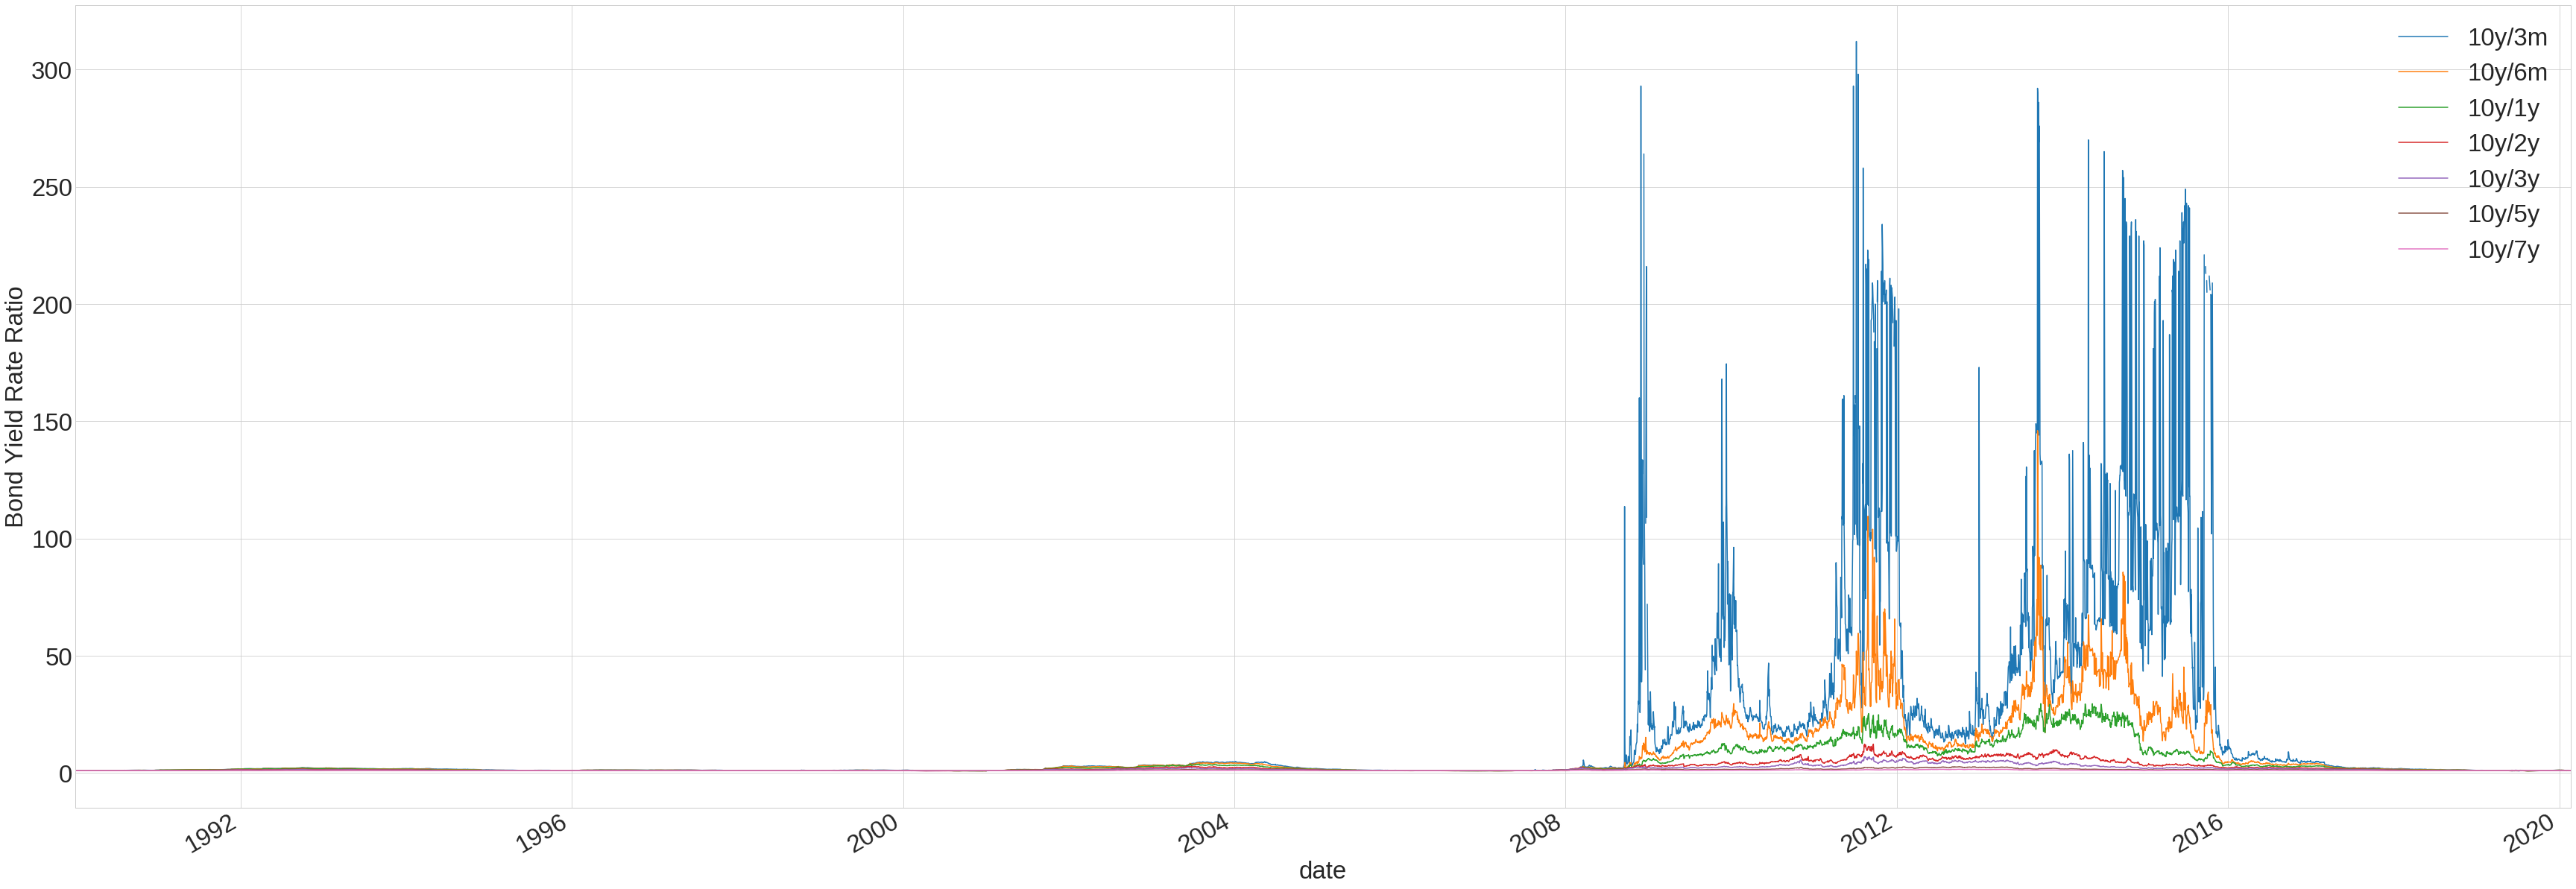

In [17]:
ax = plt.gca() #get current axes
plt.ylabel('Bond Yield Rate Ratio')
df.plot(kind='line', x='date', y='10y/3m', ax=ax)
df.plot(kind='line', x='date', y='10y/6m', ax=ax)
df.plot(kind='line', x='date', y='10y/1y', ax=ax)
df.plot(kind='line', x='date', y='10y/2y', ax=ax)
df.plot(kind='line', x='date', y='10y/3y', ax=ax)
df.plot(kind='line', x='date', y='10y/5y', ax=ax)
df.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()
# What can explain the high ratios of 2009 - 2016? 

### Bond Yield Rate Ratio for Years 2006 to 2007
Interestingly, the yield curve inverted during this period.

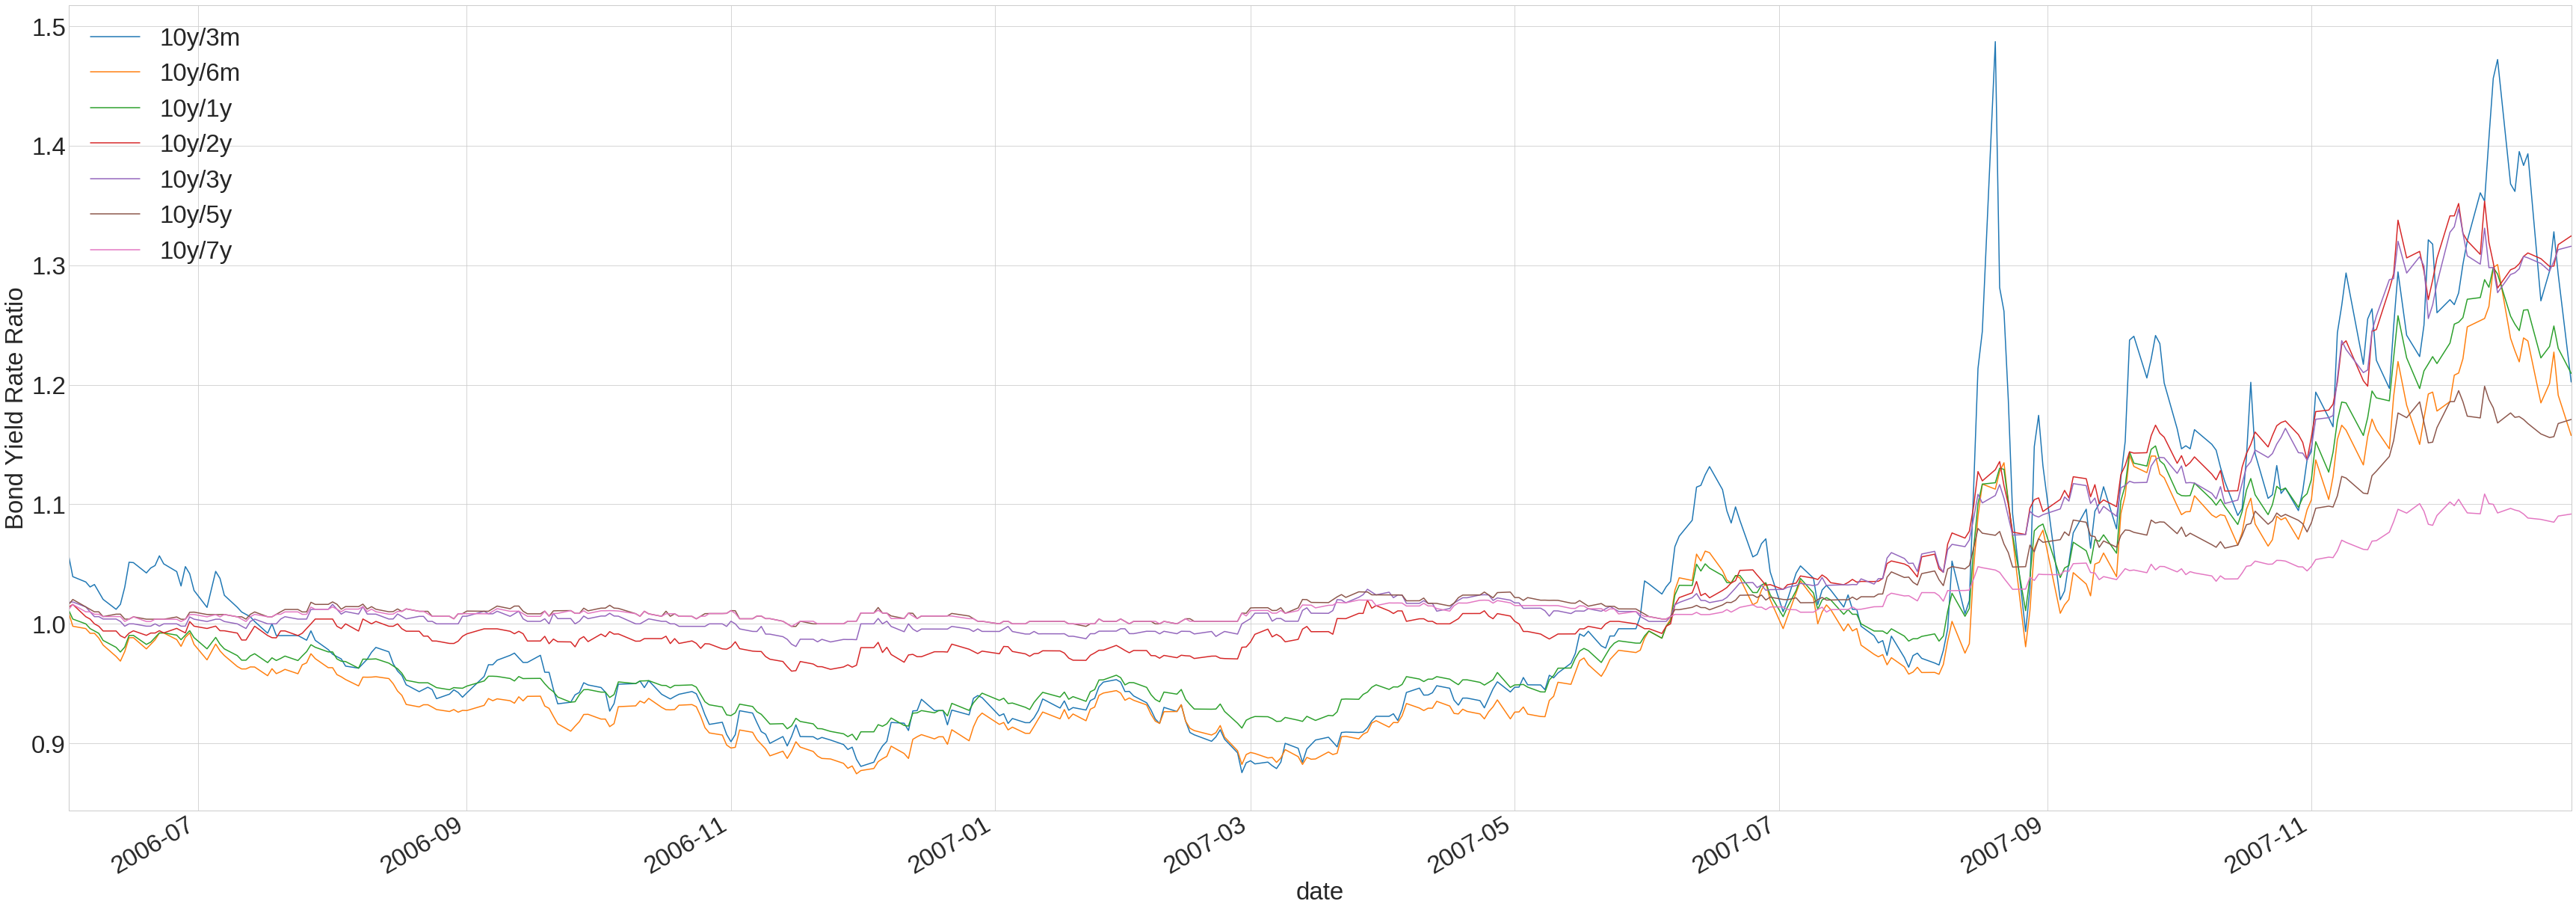

In [34]:
df_lim = df
df_lim = df_lim.loc[(df_lim['date']>='2006-06-01') & (df_lim['date']<='2008-01-01')]  # filter by date 
# df_lim = df_lim.loc[(df_lim['date']>='2006-06-01') & (df_lim['date']<='2007-08-01')  & (df_lim['10y/3m']<=1)] # filter by data
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Inversions

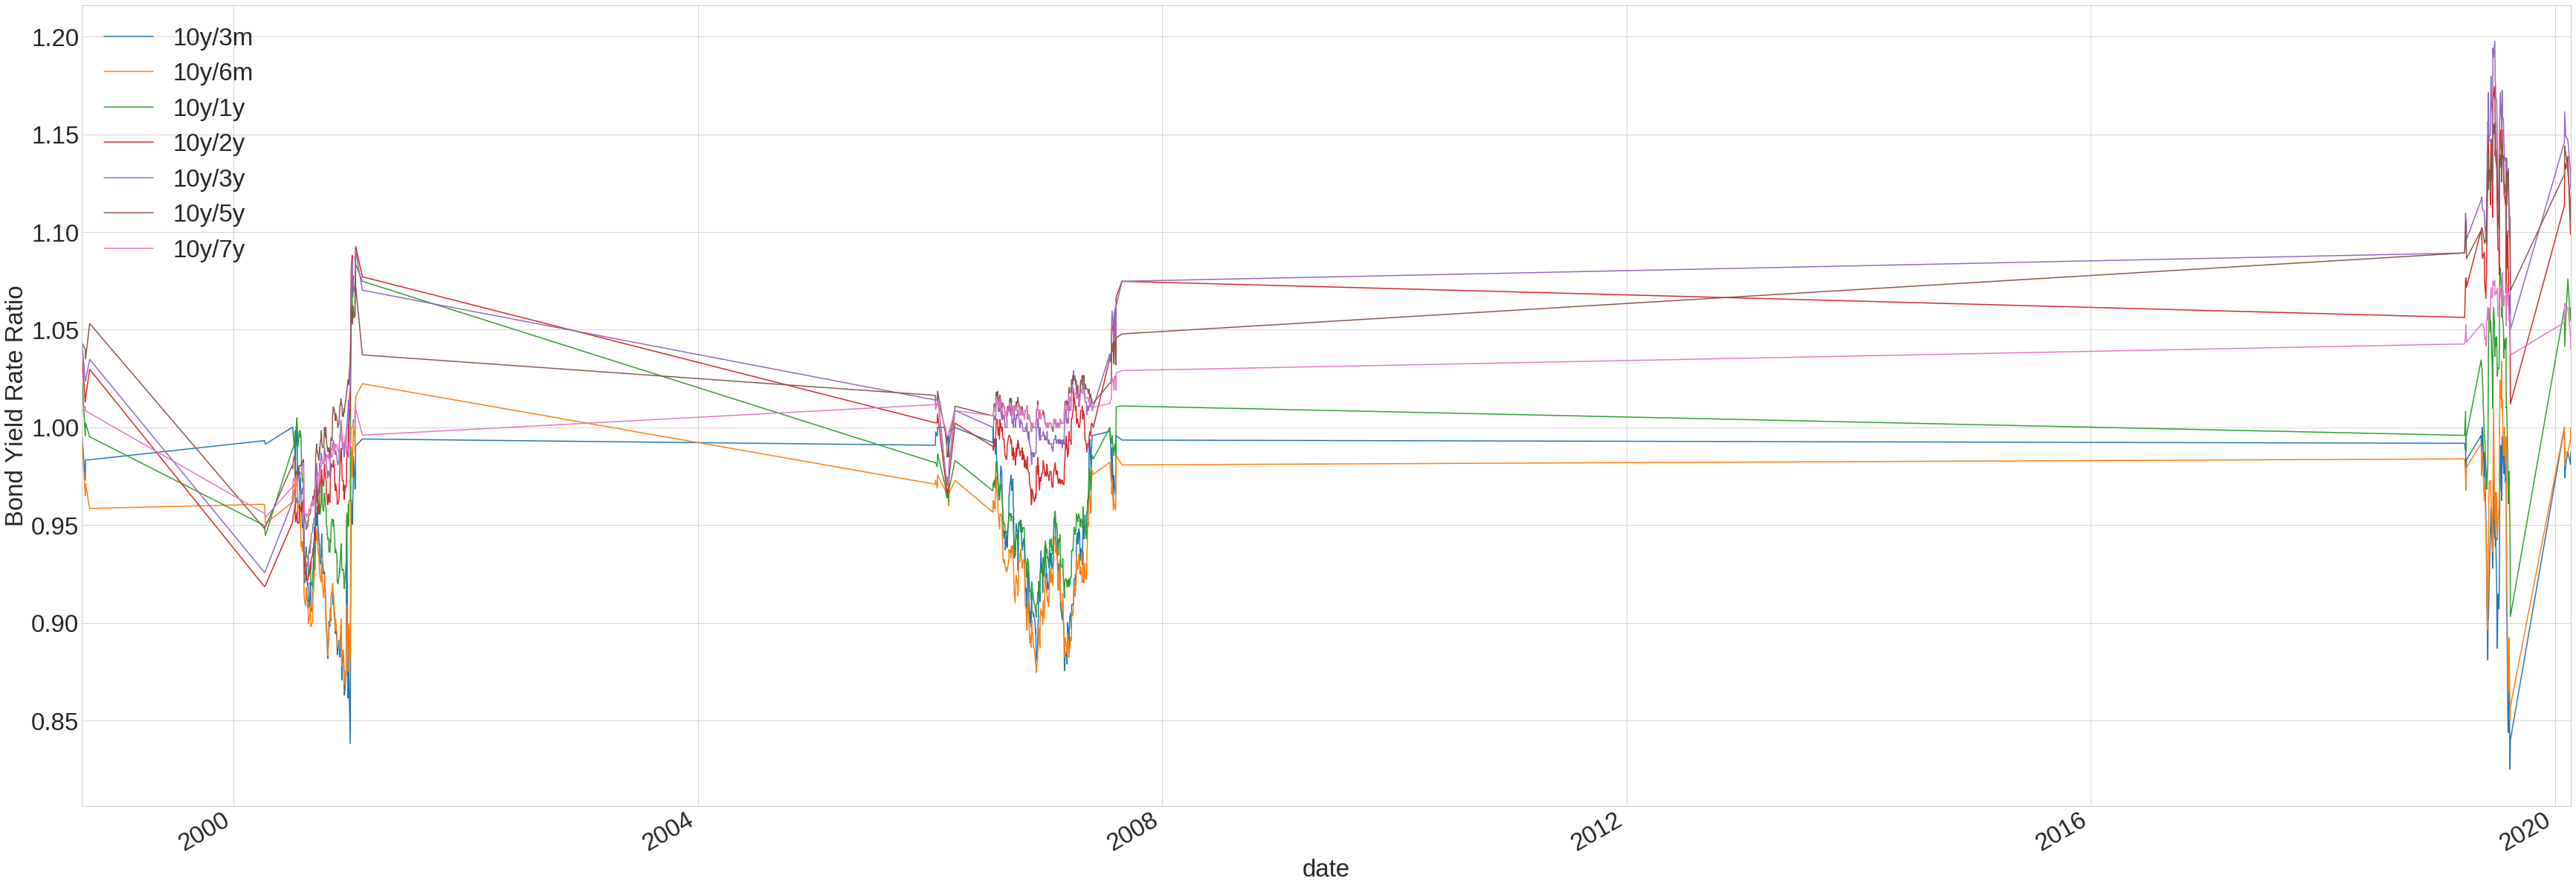

In [38]:
df_lim = df
df_lim = df_lim.loc[(df_lim['10y/3m']<=1)] # filter by data
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Ratios for 2019 to Present

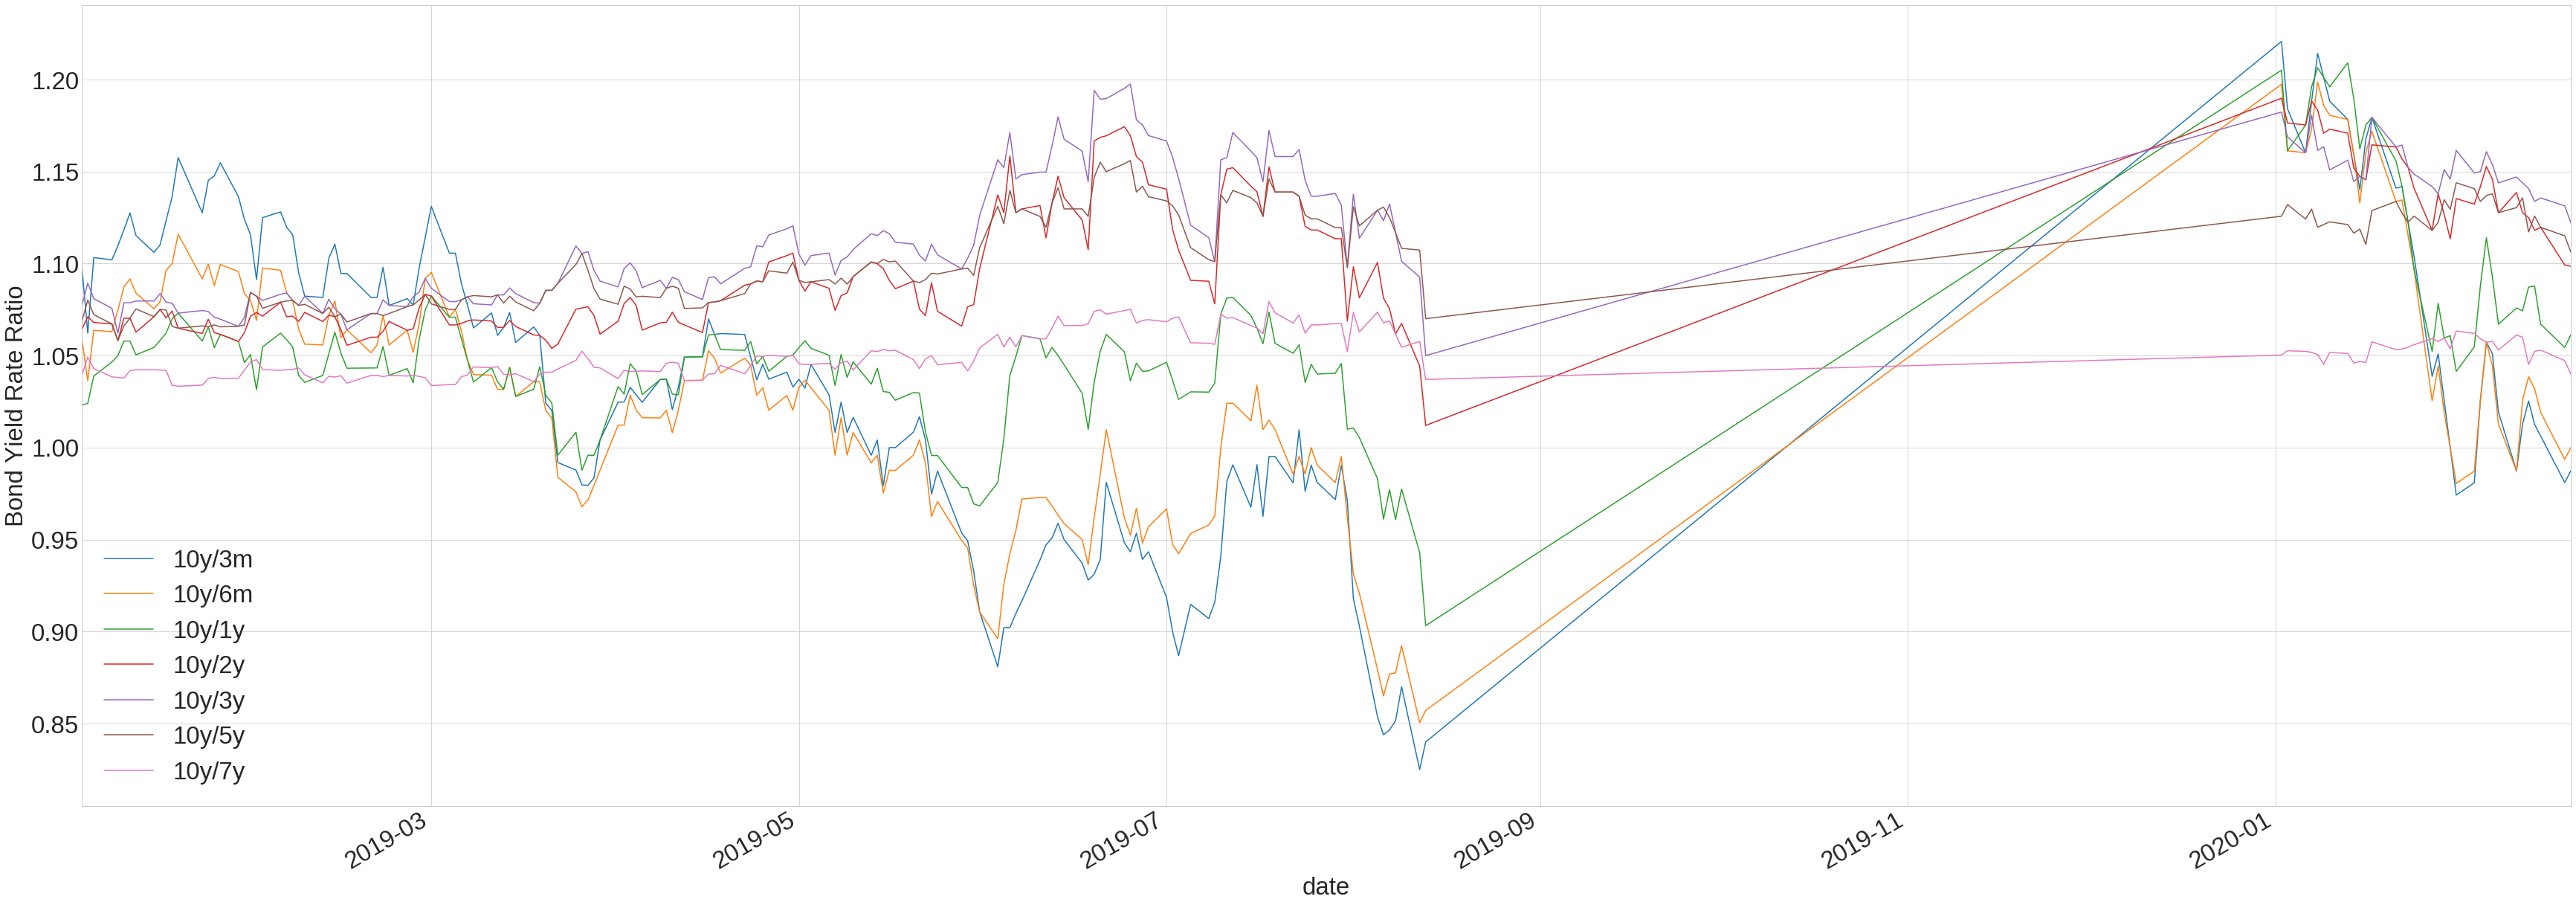

In [35]:
df_lim_18 = df
df_lim_18 = df.loc[df['date']>='2019-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_18.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()
# The gold standard 10y/3m didn't invert until the summer, but other curves had started to invert in the spring

### Bond Yield Rate Since January 2019

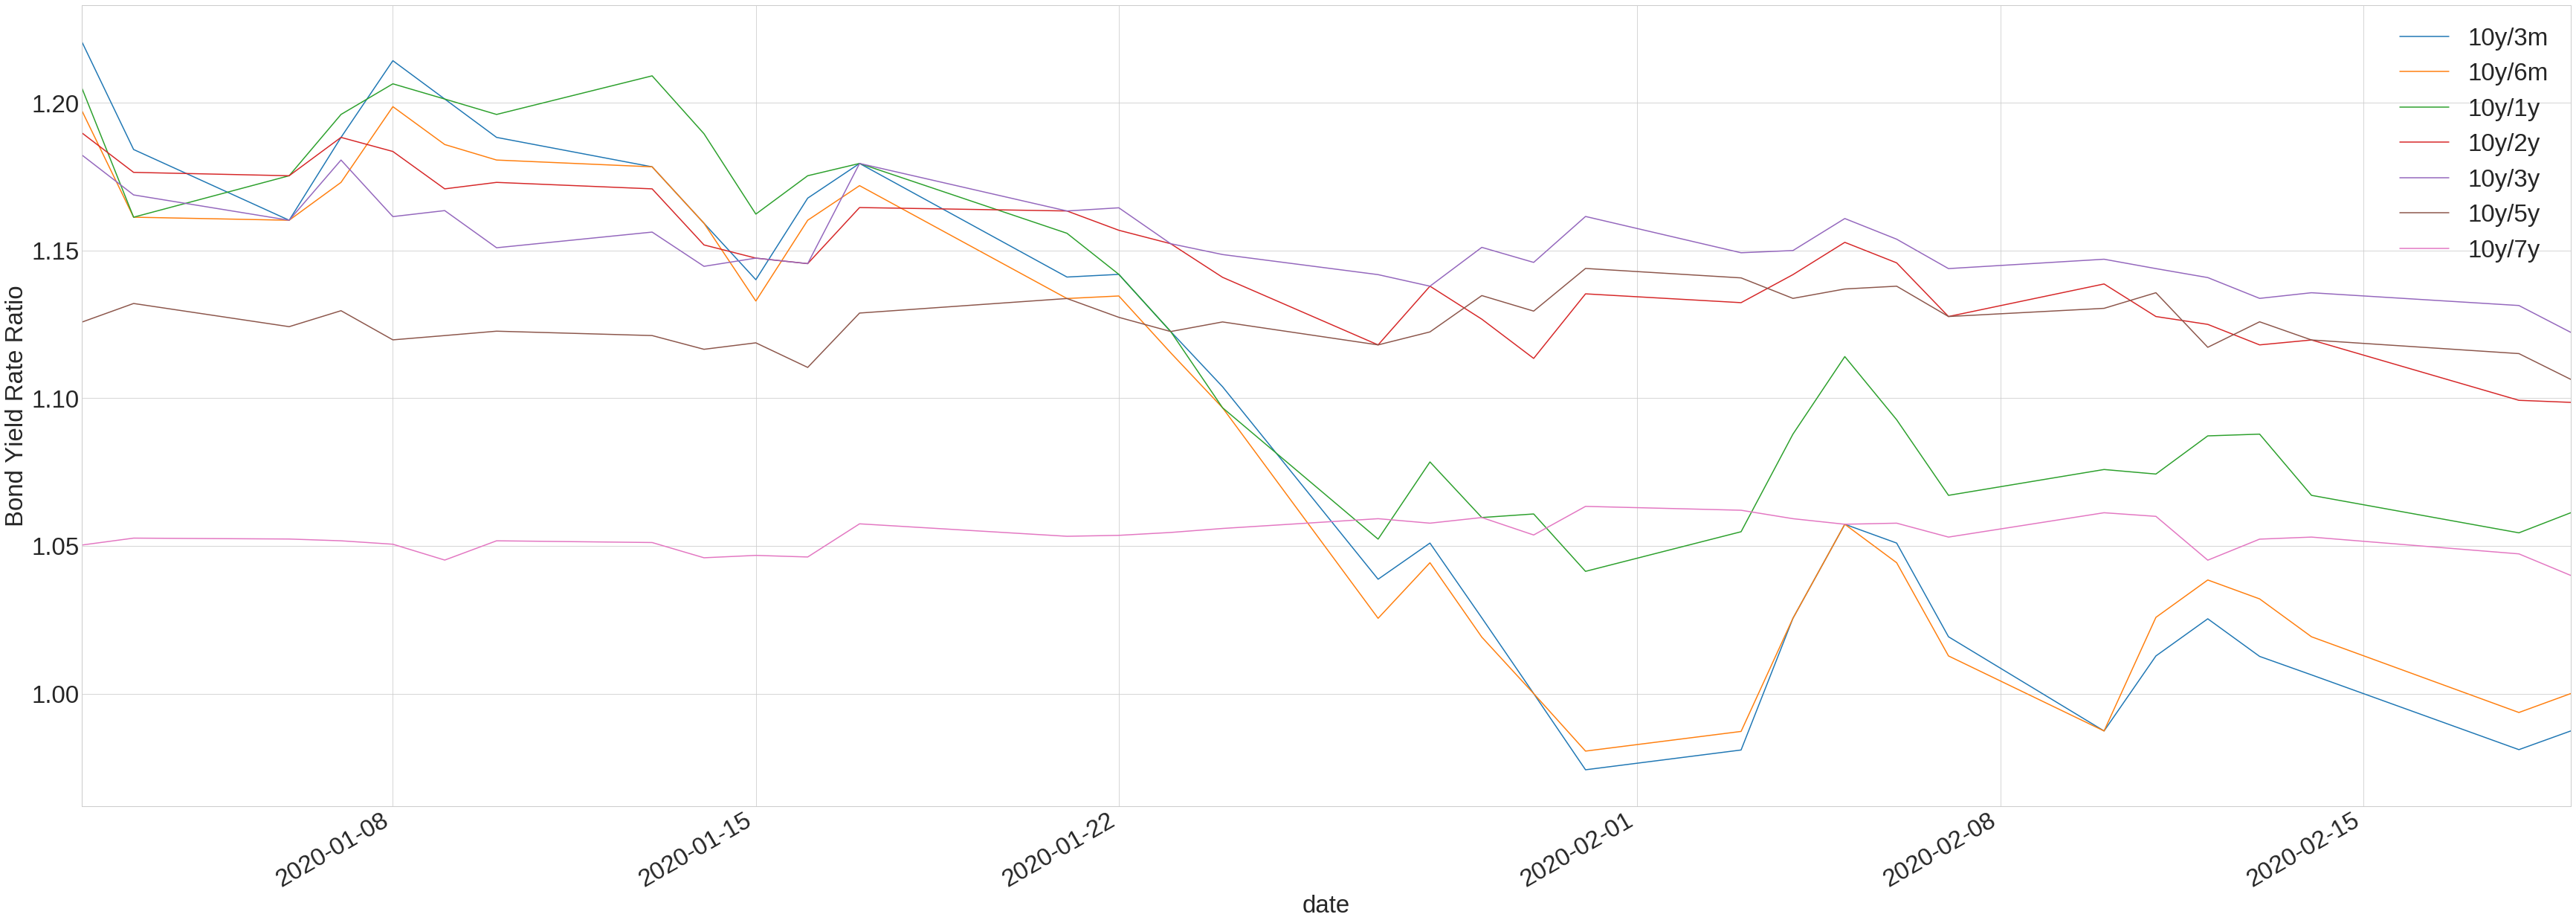

In [39]:
df_lim_20 = df
df_lim_20 = df.loc[df['date']>='2020-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_20.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

#### What does it mean? 
#### History doesn't repeat itself, but it often rhymes - Mark Twain (maybe) https://www.google.com/search?q=bond+yield+curve+inverts&source=lnms&tbm=nws&sa=X&ved=2ahUKEwiVrdfhj9nnAhUvUt8KHcfeAT4Q_AUoAnoECBAQBA&biw=2136&bih=1079

#### Publicly Available and Interesting Datasets
* Federal - https://www.data.gov/ (Agriculture, Climate, Consumer, etc.)
* Census - https://www.census.gov/data.html
* NYC Open Data - https://opendata.cityofnewyork.us/
* DC Gov - https://opendata.dc.gov/
* Kaggle - https://www.kaggle.com/
* NOAA NCDC - https://www.ncdc.noaa.gov/